# Mhealth Dataset

In this ipython notebook we'll examine some common techniques used in time series analysis by applying them to an Mhealth dataset which comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing 12 physical activities.
The different sensor reading captured over time help the analyze the ongoing activity of the subject.
The data log files downloaded from UCI machine learning repository is converted into text file and the same is used for further processing.

The dataset is available here:
https://archive.ics.uci.edu/ml/machine-learning-databases/00319/

In [20]:
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, feature_extraction
from sklearn import linear_model, svm, metrics, ensemble, tree, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import csv
from __future__ import print_function
from scipy import stats
import statsmodels.api as sm
from collections import Counter
from sklearn.cross_validation import StratifiedKFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

The above code cell includes importing the necessary modules for the functionality of the code.

To get started let us first import the data for one of the subjects and perform some data analysis to get a better understanding of how the data looks and then do complete analysis for all the 10 subjects.
These steps of feature engineering help us derive the best from the available datasets.

In [4]:
mhealth1= pd.read_csv("mHealth_subject1.txt", delim_whitespace=True, skipinitialspace=True, names=['Column_1','Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 
                                      'Column_7', 'Column_8', 'Column_9', 'Column_10', 
                                      'Column_11', 'Column_12', 'Column_13', 'Column_14', 'Column_15','Column_16','Column_17',
                            'Column_18','Column_19','Column_20','Column_21','Column_22',
                                      'Column_23','Label'])

In [8]:
print (mhealth1.columns)
print (mhealth1.shape)

Index([u'Column_1', u'Column_2', u'Column_3', u'Column_4', u'Column_5',
       u'Column_6', u'Column_7', u'Column_8', u'Column_9', u'Column_10',
       u'Column_11', u'Column_12', u'Column_13', u'Column_14', u'Column_15',
       u'Column_16', u'Column_17', u'Column_18', u'Column_19', u'Column_20',
       u'Column_21', u'Column_22', u'Column_23', u'Label'],
      dtype='object')
(161280, 24)


As seen above, we have 24 columns, 23 related to the sensor readings captured during the different activities and one for the label which specifies the activity.
Let us print the data by grouping over labels to check the number of reading available for each label. The dataset consists of readings taken over the duration of 1 min at the rate of 50 HZ and hence the count of readings per label can be reverified. 

In [10]:
mk = mhealth1.groupby('Label')
print (mk.size())

Label
0     126106
1       3072
2       3072
3       3072
4       3072
5       3072
6       3072
7       3072
8       3379
9       3072
10      3072
11      3072
12      1075
dtype: int64


The plots below can help us understand more about the dataset

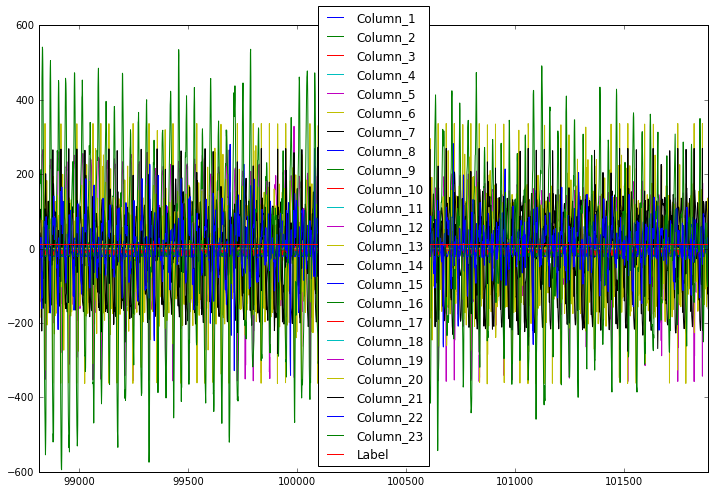

In [11]:
#Plot for different attributes for one label/ sensor readings taken over time for one activity-> Running

mhealth1.groupby('Label').get_group(11).plot(figsize=(12,8))

As it is time series relalted data we can see the attributes varying over time. To understand more about each attribute, it must be analyzed
independently for one label. Each attribute can be studied by looking at its autocorrelation and partial corelation plots.
Also trend analysis is an important part of time series data which helps us decrypt the trend,seasonality, residual componets of the data.

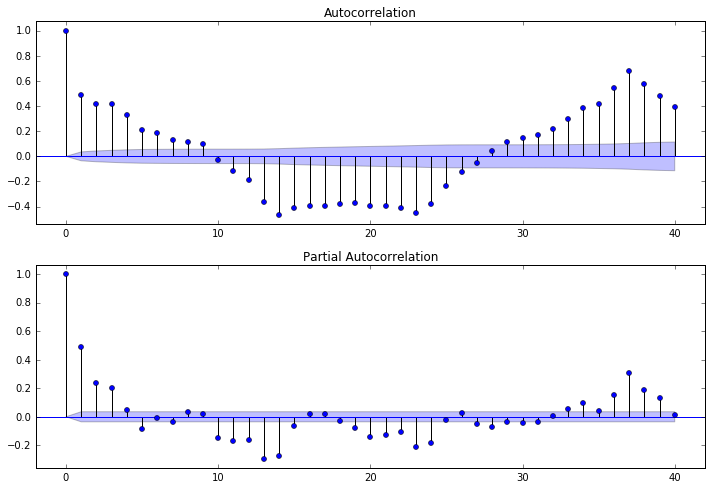

In [13]:
#Let us analyze the 'acceleration from the left-ankle sensor' readings taken over one minute (Column 6) for running activity

mk2=pd.DataFrame(mhealth1.groupby('Label').get_group(11).values)
mk3=pd.DataFrame(mk2.iloc[:,5])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mk3.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mk3.values, lags=40, ax=ax2)

Although we didn't plot them out here, the other lagged variables that we created above show similar results. 
There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually.
But getting a feel for some of the attributes we finalized the degree of our ARMA model to be 1.

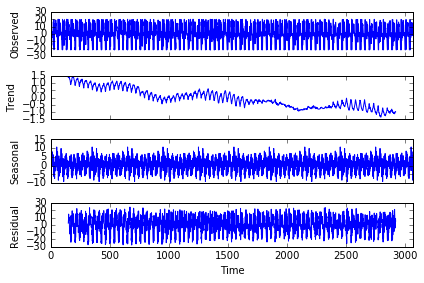

In [15]:
#Trend analysis for the same above attribute

res = sm.tsa.seasonal_decompose(mk3.values, freq=300)
resi = res.plot()

The seasonal decomposition module presents in statsmodels api of python helps us decompose our time series data into its different components.

The above plots derived for each attribute independently give us a lot of information on how the data depends on its past values and can be 
used in determining parameters for our further analysis.

Now that we have done the basic study of the basic study of the data, as we see the time series data has some trend.
We now need to get the Auto regression co-efficients for each sensor reading(attribute)corresponding to each label. So that instead of 3072
readings for each attribute for each label we just have the ARMA coefficients which can then be used for further classification.

# Lets start with loading the data for all the 10 subjects now, and storing the ARMA coefficients for each attribute and its corresponsing label.

The below includes preproecessing the data, seperating each attribute for each label and then using 'sm.tsa.ARMA' for ARMA coefficients.
Two possible scenarios are considered for further training and testing purposes:
1. Considering only the coefficients available obtained from auto regression.
2. Considering both the coefficients as well as constants obtained from auto regression.

We will be calculating and comparing the results for the both the above methods. 

In [21]:
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

Above is a function defined to split the datasets into train and test data, labels

#### Considering only the weight coefficients obtained for ARMA

In [17]:
#Mhealth1 consists of only the coefficients obtained 

filename=[]
Mhealth1= pd.DataFrame()
ind = 0

for i in range(1,11,1):
    temp=pd.read_csv("mHealth_subject"+str(i)+".txt", delim_whitespace=True, skipinitialspace=True, names=['Column_1','Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 
                                      'Column_7', 'Column_8', 'Column_9', 'Column_10', 
                                      'Column_11', 'Column_12', 'Column_13', 'Column_14', 'Column_15','Column_16','Column_17',
                            'Column_18','Column_19','Column_20','Column_21','Column_22',
                                      'Column_23','Label'])

    filename.append(temp)
    #class loop, k = class
    for k in range(1,13,1):
        Mhealth1.loc[ind, 'class'] = k
        temp2=pd.DataFrame()
        trial = pd.DataFrame(filename[i-1].groupby('Label').get_group(k))
        trial.dropna()
        trial=trial.drop(trial.columns[[23]], axis=1)
        #attribute loop, m = attribute
        for m in range (0,23,1):
            trial2=pd.DataFrame(trial.iloc[:,m])
            Mhealth1.loc[ind, m] = (sm.tsa.ARMA(trial2.values, (1,0)).fit()).params[1]
        ind+=1
        
#print (Mhealth1)

C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [6]:
print (Mhealth1.shape)

(120, 24)

As seen above, we now have the coefficients derived for all sensor reading along with the label column.
The data is for 12 activities for 10 subjects and hence the 120 rows and 24 columns.

###### Preprocess the data to get the constant as well as weight coefficient for ARMA models and store the same in Mhealth2 which will be used for further calculations


In [7]:
#Mhealth2 deals with both the constant as well as coefficients obtained from auto regression

filename=[]
Mhealth2= pd.DataFrame()
ind = 0

for i in range(1,11,1):
    temp=pd.read_csv("mHealth_subject"+str(i)+".txt", delim_whitespace=True, skipinitialspace=True, names=['Column_1','Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 
                                      'Column_7', 'Column_8', 'Column_9', 'Column_10', 
                                      'Column_11', 'Column_12', 'Column_13', 'Column_14', 'Column_15','Column_16','Column_17',
                            'Column_18','Column_19','Column_20','Column_21','Column_22',
                                      'Column_23','Label'])

    filename.append(temp)
    #class loop, k = class
    for k in range(1,13,1):
        Mhealth2.loc[ind, 'class'] = k
        temp2=pd.DataFrame()
        trial = pd.DataFrame(filename[i-1].groupby('Label').get_group(k))
        trial.dropna()
        trial=trial.drop(trial.columns[[23]], axis=1)
        #attribute loop, m = attribute
        ind2=0
        for m in range (0,23,1):
            trial2=pd.DataFrame(trial.iloc[:,m])
            arma=sm.tsa.ARMA(trial2.values, (1,0)).fit()
            Mhealth2.loc[ind, ind2] = arma.params[0]
            ind2+=1
            Mhealth2.loc[ind, ind2] = arma.params[1]
            ind2+=1
        ind+=1
        
print (Mhealth2.shape)

C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

(120, 47)


# Part 1: Training and testing considering only the coefficients obtained.

In [18]:
# Seperate attributes and lebels from the new data derived from auto regression

mhealth_attrs = Mhealth1.iloc[:,1:]
mhealth_labels = Mhealth1.iloc[:,0]

mhealth_10stratified = StratifiedKFold(mhealth_labels, n_folds=10,random_state=20160121, shuffle=True)

The entire dataset derived above is now seperated into labels and attributes.
We Will be splitting the train and test data set using StratifiedKFold for 10 folds for some further calculations

We will be using the different classifier modules available in scikit learn package for fitting our data and then assessing the predictions made by different data mining tools by comparing their accuracies.

### One Vs One Classifier using Logistic Regression

In [11]:
lr = OneVsOneClassifier(linear_model.LogisticRegression())
fold_results = pd.DataFrame()
count = 0
foldnum = 0
for train, test in mhealth_10stratified:
    foldnum+=1
    count+=1
    [mhealth_tr_data, mhealth_te_data,
     mhealth_tr_target, mhealth_te_target] = folds_to_split(mhealth_attrs, mhealth_labels,train,test) 
    lr.fit(mhealth_tr_data.values, mhealth_tr_target['class'].values)
    
    estimator_prediction = lr.estimators_[0].predict(mhealth_te_data)
    prediction = lr.predict(mhealth_te_data)
    acc = metrics.accuracy_score(prediction,mhealth_te_target)
    
    print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
    
    # But a nicer way to store them is in a DataFrame
    fold_results.loc[count, 'Overall_accuracy'] = acc

print ("\n Average values over 10 folds\n", fold_results.mean())


Fold #1 -> Overall accuracy metric = 0.833 	

Fold #2 -> Overall accuracy metric = 0.417 	

Fold #3 -> Overall accuracy metric = 0.583 	

Fold #4 -> Overall accuracy metric = 0.750 	

Fold #5 -> Overall accuracy metric = 0.750 	

Fold #6 -> Overall accuracy metric = 0.500 	

Fold #7 -> Overall accuracy metric = 0.667 	

Fold #8 -> Overall accuracy metric = 0.667 	

Fold #9 -> Overall accuracy metric = 0.833 	

Fold #10 -> Overall accuracy metric = 0.750 	

 Average values over 10 folds
 Overall_accuracy    0.675
dtype: float64


##### The overall Accuracy using OneVsOne Classifier using logistic regression is 67.5%

### One Vs Rest Classifier using Logistic Regression

In [12]:
lr = OneVsRestClassifier(linear_model.LogisticRegression())
fold_results = pd.DataFrame()
count = 0
foldnum = 0
for train, test in mhealth_10stratified:
    foldnum+=1
    count+=1
    [mhealth_tr_data, mhealth_te_data,
     mhealth_tr_target, mhealth_te_target] = folds_to_split(mhealth_attrs, mhealth_labels,train,test) 
    lr.fit(mhealth_tr_data.values, mhealth_tr_target['class'].values)
    
    estimator_prediction = lr.estimators_[0].predict(mhealth_te_data)
    prediction = lr.predict(mhealth_te_data)
    acc = metrics.accuracy_score(prediction,mhealth_te_target)
    print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
    fold_results.loc[count, 'Overall_accuracy'] = acc

print ("\n Average values over 10 folds\n", fold_results.mean())


Fold #1 -> Overall accuracy metric = 0.833 	

Fold #2 -> Overall accuracy metric = 0.417 	

Fold #3 -> Overall accuracy metric = 0.583 	

Fold #4 -> Overall accuracy metric = 0.833 	

Fold #5 -> Overall accuracy metric = 0.750 	

Fold #6 -> Overall accuracy metric = 0.750 	

Fold #7 -> Overall accuracy metric = 0.750 	

Fold #8 -> Overall accuracy metric = 0.833 	

Fold #9 -> Overall accuracy metric = 0.833 	

Fold #10 -> Overall accuracy metric = 0.750 	

 Average values over 10 folds
 Overall_accuracy    0.733333
dtype: float64


##### The overall Accuracy using OneVsRest Classifier using logistic regression is 73.33%

### Classification using decision trees

As decision trees are a popular approach to classification of discrete labels we will classfying our data for decision trees and compare its accuracy across various depths.

In [25]:
# Try Decision tree classifier on the above data

dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy')

In [28]:
## Stratification on mhealth (tree classifier)

numberOfFold = 10
mhealth_10stratified = StratifiedKFold(mhealth_labels, n_folds=numberOfFold, random_state=20160121, shuffle=True)

In [30]:
print("where the `max_depth` parameter varies from 1 to 8")
maxDepth = range(1,9)
for i in maxDepth:
    accuracy = 0
    for trainVal, test in mhealth_10stratified:
            #test has index value of all the instances chosen for testing, make a separate array for that
            
            [mhealth_training4, mhealth_validation4, mhealth_training_labels4, mhealth_validation_labels4] = folds_to_split(mhealth_attrs, mhealth_labels, trainVal, test)
            
            dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy', max_depth = i)
            dtree.fit(mhealth_training4, mhealth_training_labels4);
            accuracy += dtree.score(mhealth_validation4, mhealth_validation_labels4);
            #to calculate error, we subtract accuracy from 1
            #accuracy divided by 4 since 4-Fold
    print ("maxDepth = {0} :: accuracy = {1}".format(i, (accuracy/numberOfFold)))

where the `max_depth` parameter varies from 1 to 8
maxDepth = 1 :: accuracy = 0.158333333333
maxDepth = 2 :: accuracy = 0.3
maxDepth = 3 :: accuracy = 0.575
maxDepth = 4 :: accuracy = 0.733333333333
maxDepth = 5 :: accuracy = 0.725
maxDepth = 6 :: accuracy = 0.741666666667
maxDepth = 7 :: accuracy = 0.741666666667
maxDepth = 8 :: accuracy = 0.741666666667


##### A uniform accuracy of 74.16% using the decision tree classifier is obtained after tree depth of 6 onwards.

### Classification using K nearest neighbours

In [35]:
Mhealth1_knn_results = pd.DataFrame()
foldnum=0
for train, test in cross_validation.KFold(len(mhealth_labels), shuffle=True, n_folds=5,
                                           random_state=20160217):
    foldnum+=1
    [mhealth_tr_data, mhealth_te_data, 
     mhealth_tr_targets, mhealth_te_targets] = folds_to_split(mhealth_attrs, mhealth_labels, train, test)
    # Give neighbors equal weight (uniform) or base weight on distance
    for weight in ['uniform', 'distance']:
        # Use 1, 2 or 15 neighbors to deteremine the class
        for k in [1, 5, 15]:
            #Use L1 (Manhattan), L2 (Euclidean), or L100 (approaching supremum distance)
            for degree in [1, 2, 100]:
                knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
                knn.fit(mhealth_tr_data.values, mhealth_tr_targets.values.ravel())
                Mhealth1_knn_results.loc[foldnum, 
                                     'k={:<5}p={:<8}w={:<10}'.format(k, 
                                                                     degree, 
                                                                     weight)] = knn.score(mhealth_te_data.values,
                                                                                          mhealth_te_targets.values.ravel())
print ("Results for different parameters of K-Nearest Neighbors")
print (Mhealth1_knn_results.mean().apply(lambda x : '%0.3f' % x))

Results for different parameters of K-Nearest Neighbors
k=1    p=1       w=uniform       0.708
k=1    p=2       w=uniform       0.617
k=1    p=100     w=uniform       0.567
k=5    p=1       w=uniform       0.708
k=5    p=2       w=uniform       0.625
k=5    p=100     w=uniform       0.525
k=15   p=1       w=uniform       0.558
k=15   p=2       w=uniform       0.475
k=15   p=100     w=uniform       0.367
k=1    p=1       w=distance      0.708
k=1    p=2       w=distance      0.617
k=1    p=100     w=distance      0.567
k=5    p=1       w=distance      0.742
k=5    p=2       w=distance      0.667
k=5    p=100     w=distance      0.575
k=15   p=1       w=distance      0.675
k=15   p=2       w=distance      0.608
k=15   p=100     w=distance      0.475
dtype: object


##### The maximum accuracy obtained using KNN for 1 neighbor, 1 degree and uniform/distance weights is 70.8%

# Part 2: Training and testing considering only the coefficients obtained.

In [36]:
# Seperate attributes and lebels from the new data derived from auto regression

mhealth_attrs = Mhealth2.iloc[:,1:]
mhealth_labels = Mhealth2.iloc[:,0]

mhealth_10stratified = StratifiedKFold(mhealth_labels, n_folds=10,random_state=20160121, shuffle=True)

### One Vs One using logistic regression

In [37]:
lr = OneVsOneClassifier(linear_model.LogisticRegression())
fold_results = pd.DataFrame()
count = 0
foldnum = 0
for train, test in mhealth_10stratified:
    foldnum+=1
    count+=1
    [mhealth_tr_data, mhealth_te_data,
     mhealth_tr_target, mhealth_te_target] = folds_to_split(mhealth_attrs, mhealth_labels,train,test) 
    lr.fit(mhealth_tr_data.values, mhealth_tr_target['class'].values)
    
    estimator_prediction = lr.estimators_[0].predict(mhealth_te_data)
    prediction = lr.predict(mhealth_te_data)
    acc = metrics.accuracy_score(prediction,mhealth_te_target)
    
    print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
    
    # But a nicer way to store them is in a DataFrame
    fold_results.loc[count, 'Overall_accuracy'] = acc

print ("\n Average values over 10 folds\n", fold_results.mean())


Fold #1 -> Overall accuracy metric = 1.000 	

Fold #2 -> Overall accuracy metric = 0.833 	

Fold #3 -> Overall accuracy metric = 0.917 	

Fold #4 -> Overall accuracy metric = 1.000 	

Fold #5 -> Overall accuracy metric = 0.917 	

Fold #6 -> Overall accuracy metric = 1.000 	

Fold #7 -> Overall accuracy metric = 0.833 	

Fold #8 -> Overall accuracy metric = 0.833 	

Fold #9 -> Overall accuracy metric = 0.917 	

Fold #10 -> Overall accuracy metric = 0.917 	

 Average values over 10 folds
 Overall_accuracy    0.916667
dtype: float64


##### The overall Accuracy using OneVsRest Classifier using logistic regression is 91.66%

### One Vs Rest using logistic regression

In [38]:
lr = OneVsRestClassifier(linear_model.LogisticRegression())
fold_results = pd.DataFrame()
count = 0
foldnum = 0
for train, test in mhealth_10stratified:
    foldnum+=1
    count+=1
    [mhealth_tr_data, mhealth_te_data,
     mhealth_tr_target, mhealth_te_target] = folds_to_split(mhealth_attrs, mhealth_labels,train,test) 
    lr.fit(mhealth_tr_data.values, mhealth_tr_target['class'].values)
    
    estimator_prediction = lr.estimators_[0].predict(mhealth_te_data)
    prediction = lr.predict(mhealth_te_data)
    acc = metrics.accuracy_score(prediction,mhealth_te_target)
    
    print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
    
    # But a nicer way to store them is in a DataFrame
    fold_results.loc[count, 'Overall_accuracy'] = acc

print ("\n Average values over 10 folds\n", fold_results.mean())


Fold #1 -> Overall accuracy metric = 0.917 	

Fold #2 -> Overall accuracy metric = 1.000 	

Fold #3 -> Overall accuracy metric = 0.833 	

Fold #4 -> Overall accuracy metric = 0.917 	

Fold #5 -> Overall accuracy metric = 1.000 	

Fold #6 -> Overall accuracy metric = 0.833 	

Fold #7 -> Overall accuracy metric = 0.667 	

Fold #8 -> Overall accuracy metric = 0.833 	

Fold #9 -> Overall accuracy metric = 0.833 	

Fold #10 -> Overall accuracy metric = 0.917 	

 Average values over 10 folds
 Overall_accuracy    0.875
dtype: float64


##### The overall Accuracy using OneVsRest Classifier using logistic regression is 87.5%

### Classification using decision trees

In [39]:
# Try Decision tree classifier on the above data

dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy')
## Stratification on mhealth (tree classifier)

numberOfFold = 10
mhealth_10stratified = StratifiedKFold(mhealth_labels, n_folds=numberOfFold, random_state=20160121, shuffle=True)

print("where the `max_depth` parameter varies from 1 to 8")
maxDepth = range(1,9)
for i in maxDepth:
    accuracy = 0
    for trainVal, test in mhealth_10stratified:
            #test has index value of all the instances chosen for testing, make a separate array for that
            
            [mhealth_training4, mhealth_validation4, mhealth_training_labels4, mhealth_validation_labels4] = folds_to_split(mhealth_attrs, mhealth_labels, trainVal, test)
            
            dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy', max_depth = i)
            dtree.fit(mhealth_training4, mhealth_training_labels4);
            accuracy += dtree.score(mhealth_validation4, mhealth_validation_labels4);
            #to calculate error, we subtract accuracy from 1
            #accuracy divided by 4 since 4-Fold
    print ("maxDepth = {0} :: accuracy = {1}".format(i, (accuracy/numberOfFold)))


where the `max_depth` parameter varies from 1 to 8
maxDepth = 1 :: accuracy = 0.158333333333
maxDepth = 2 :: accuracy = 0.316666666667
maxDepth = 3 :: accuracy = 0.608333333333
maxDepth = 4 :: accuracy = 0.925
maxDepth = 5 :: accuracy = 0.875
maxDepth = 6 :: accuracy = 0.875
maxDepth = 7 :: accuracy = 0.875
maxDepth = 8 :: accuracy = 0.875


##### A uniform accuracy of 87.5% using the decision tree classifier is obtained after tree depth of 5 onwards.

### Classification using K nearest neighbours

In [40]:
Mhealth1_knn_results = pd.DataFrame()
foldnum=0
for train, test in cross_validation.KFold(len(mhealth_labels), shuffle=True, n_folds=5,
                                           random_state=20160217):
    foldnum+=1
    [mhealth_tr_data, mhealth_te_data, 
     mhealth_tr_targets, mhealth_te_targets] = folds_to_split(mhealth_attrs, mhealth_labels, train, test)
    # Give neighbors equal weight (uniform) or base weight on distance
    for weight in ['uniform', 'distance']:
        # Use 1, 2 or 15 neighbors to deteremine the class
        for k in [1, 5, 15]:
            #Use L1 (Manhattan), L2 (Euclidean), or L100 (approaching supremum distance)
            for degree in [1, 2, 100]:
                knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
                knn.fit(mhealth_tr_data.values, mhealth_tr_targets.values.ravel())
                Mhealth1_knn_results.loc[foldnum, 
                                     'k={:<5}p={:<8}w={:<10}'.format(k, 
                                                                     degree, 
                                                                     weight)] = knn.score(mhealth_te_data.values,
                                                                                          mhealth_te_targets.values.ravel())
print ("Results for different parameters of K-Nearest Neighbors")
print (Mhealth1_knn_results.mean().apply(lambda x : '%0.3f' % x))

Results for different parameters of K-Nearest Neighbors
k=1    p=1       w=uniform       0.892
k=1    p=2       w=uniform       0.908
k=1    p=100     w=uniform       0.842
k=5    p=1       w=uniform       0.925
k=5    p=2       w=uniform       0.900
k=5    p=100     w=uniform       0.783
k=15   p=1       w=uniform       0.717
k=15   p=2       w=uniform       0.617
k=15   p=100     w=uniform       0.650
k=1    p=1       w=distance      0.892
k=1    p=2       w=distance      0.908
k=1    p=100     w=distance      0.842
k=5    p=1       w=distance      0.925
k=5    p=2       w=distance      0.892
k=5    p=100     w=distance      0.833
k=15   p=1       w=distance      0.867
k=15   p=2       w=distance      0.825
k=15   p=100     w=distance      0.750
dtype: object


##### The maximum accuracy obtained using KNN for 5 neighbor, 1 degree and uniform/distance weights is 92.5%